This notebook shows the transfer learning process done with the CheXNet architecture and weights. Training was done on the servers of NAIST's Computational Systems Biology Laboratory. We first load some necessary libraries.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, InputLayer, Resizing, RandomRotation, Normalization
from keras.models import Sequential
import pandas as pd
import os

Checking GPU Access

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Importing the Dataset

In [4]:
dir_data = '/project/dsc-is/napi/dat0/'

In [5]:
if not "data_all" in globals():
    tmp = np.load(os.path.join(dir_data, 'pix_w256_1.npz'))
    data1 = tmp['arr_0']
    print(data1.shape)
    tmp = np.load(os.path.join(dir_data, 'pix_w256_2.npz'))
    data2 = tmp['arr_0']
    print(data2.shape)
    
    data_all = np.concatenate((data1,data2), axis=0).reshape((-1,256,256,1)) # tensorflow is channels last
    del data1
    del data2

print(data_all.shape)

(50297, 256, 256)
(32700, 256, 256)
(82997, 256, 256, 1)


Getting the Diagnosis

In [6]:
diagnosis1 = pd.read_csv(os.path.join(dir_data, 'diagnosis_new.txt'), sep='\t', header=None)
yyy_scoliosis = (diagnosis1.iloc[:,4]=="有").to_numpy().astype(int)

Below, we see that the dataset is highly imbalanced, so this should be taken care of during training.

In [7]:
np.sum(yyy_scoliosis), yyy_scoliosis.shape[0], 100 * np.sum(yyy_scoliosis) / yyy_scoliosis.shape[0]

(1308, 82997, 1.5759605768883214)

Data Augmentation

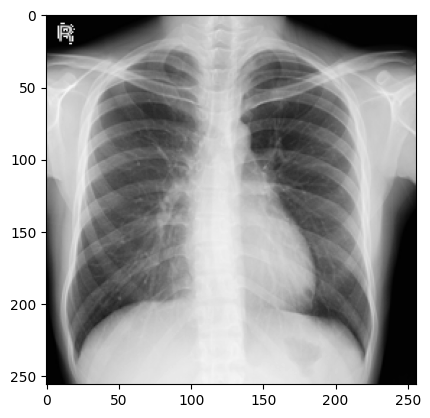

In [8]:
plt.imshow(data_all[0] / 255, cmap = 'gray')
plt.show()

In [9]:
def transform_image(image):
  image = tf.broadcast_to(tf.convert_to_tensor(image / 255), [256, 256, 3])
  return image

For this project, we implement a simple random rotation for data augmentation. We also resize our images to 224 x 224 since this is the expected input size for CheXNet. Finally, we then do some normalization, as this is also expected from the inputs of the CheXNet model.

In [10]:
preprocessing = Sequential([
                            InputLayer(input_shape = (256, 256, 3)),
                            Resizing(224, 224),
                            RandomRotation(15/360),
                            Normalization(mean = [0.485, 0.456, 0.406], variance = np.square([0.229, 0.224, 0.225]))
])

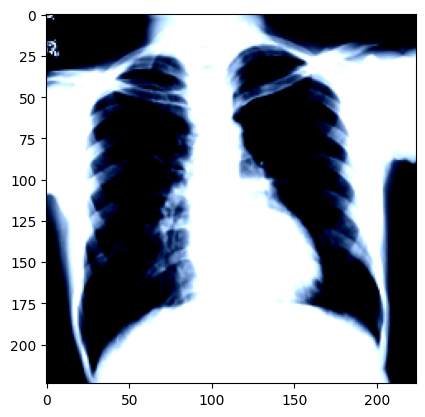

In [11]:
plt.imshow(np.squeeze(np.clip(preprocessing(tf.broadcast_to(transform_image(data_all[0]), shape = (1, 256, 256, 3))), 0, 1), axis = 0), cmap = 'gray')
plt.show()

Train, Test, and Validation Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_all, yyy_scoliosis, test_size = 0.15)

del data_all
del yyy_scoliosis

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(63492, 256, 256, 1) (12450, 256, 256, 1) (7055, 256, 256, 1) (63492,) (12450,) (7055,)


Due to memory limitations, we set our batch size to 16. We then compute for the minimum number of epochs needed to see all the negative instances, with the assumption that each batch of size 16 contains 8 instances from both the positive and negative class (essentially oversampling the positive class).

In [13]:
steps_per_epoch = int(np.ceil(2*(y_train.shape[0] - np.sum(y_train)) / 16))
np.sum(y_train), y_train.shape[0], 100 * np.sum(y_train) / y_train.shape[0], steps_per_epoch

(994, 63492, 1.5655515655515655, 7813)

We use the tf.Data API to preprocess the dataset, allowing us to configure each training batch to have a balanced number of instances from both classes.

In [14]:
def preprocess(images, labels, train = True):
  if train:
    pos = labels == 1
    pos_images = images[pos]
    neg_images = images[~pos]
    pos_labels = labels[pos]
    neg_labels = labels[~pos]
    pos_ds = tf.data.Dataset.from_tensor_slices((pos_images, pos_labels)).shuffle(100000).repeat()
    neg_ds = tf.data.Dataset.from_tensor_slices((neg_images, neg_labels)).shuffle(100000).repeat()
    resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights = [0.5, 0.5])
    resampled_ds = resampled_ds.map(lambda x, y : (transform_image(x), y), num_parallel_calls = tf.data.AUTOTUNE)
    resampled_ds = resampled_ds.batch(16).prefetch(tf.data.AUTOTUNE)
    return resampled_ds
  else:
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.map(lambda x, y : (transform_image(x), y), num_parallel_calls = tf.data.AUTOTUNE)
    ds = ds.shuffle(100000).batch(16).prefetch(tf.data.AUTOTUNE)    
    return ds

In [15]:
train_ds = preprocess(X_train, y_train)
val_ds = preprocess(X_val, y_val, train = False)
test_ds = preprocess(X_test, y_test, train = False)

We now create the "CNN portion" of our model that is based on CheXNet. Note that CheXNet's architecture is based on DenseNet121. Here, we use the pretrained weights of CheXNet from the repository https://github.com/brucechou1983/CheXNet-Keras. This weights file assumes a final dense layer with 14 units, which is why we set DenseNet121 to have that many classes. Since our task is binary classification, we will simply remove this final dense layer later on. 

In [26]:
weights_path = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
pre_trained_chexnet = tf.keras.applications.densenet.DenseNet121(include_top = True, 
                                                                 weights = None,
                                                                 input_shape = (224, 224, 3),
                                                                 classes = 14 
                                                                 )
pre_trained_chexnet.load_weights(weights_path)

In [27]:
print(f'Last Layer : {str(pre_trained_chexnet.layers[-1])}') 
print('------------------------------------------------------')
print(f'Second to the last layer : {str(pre_trained_chexnet.layers[-2])}') 
print('------------------------------------------------------')
print(f'Number of Parameters : {pre_trained_chexnet.count_params()}')

Last Layer : <keras.layers.core.dense.Dense object at 0x7fd9884fab20>
------------------------------------------------------
Second to the last layer : <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fd9884faa60>
------------------------------------------------------
Number of Parameters : 7051854


We now remove the final dense layer.

In [28]:
pre_trained_chexnet = tf.keras.Model(inputs = pre_trained_chexnet.input, outputs = pre_trained_chexnet.layers[-2].output) # Source : https://github.com/tensorflow/tensorflow/issues/22479#issuecomment-979750528

print(f'Last Layer : {str(pre_trained_chexnet.layers[-1])}') 
print('------------------------------------------------------')
print(f'Second to the last layer : {str(pre_trained_chexnet.layers[-2])}') 
print('------------------------------------------------------')
print(f'Number of Parameters : {pre_trained_chexnet.count_params()}')

Last Layer : <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fd9884faa60>
------------------------------------------------------
Second to the last layer : <keras.layers.core.activation.Activation object at 0x7fd988562580>
------------------------------------------------------
Number of Parameters : 7037504


Finally, we now combine our preprocessing layers, CheXNet-based layers, and a final dense layer with 1 unit to form our final model. We set our CheXNet layers to be untrainable initially.

In [29]:
pre_trained_chexnet.trainable = False

classifier = Sequential([
                         Dense(1, activation = 'sigmoid')])
model = Sequential([preprocessing, 
                    pre_trained_chexnet,
                    classifier], 
                   name = 'transfer_learning_chexnet')

To see if it works, we try to use it on a random "image".

In [30]:
model.predict(np.random.normal(size = (1, 256, 256, 3)))

array([[0.43439353]], dtype=float32)

We then look at the model summary.

In [31]:
model.summary()

Model: "transfer_learning_chexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 1024)              7037504   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


After a lot of trial and error, I finally settled to the following training process. This consists of an initial training that only modifies the weights of the final dense layer, and a final training which allows all the weights of the entire model to be modified.

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("chexnet_transfer_learning_gpu.h5", save_best_only=True)

In [33]:
with tf.device('/GPU:0'):
    history = model.fit(x = train_ds,
                    epochs = 10, 
                    callbacks = [checkpoint_cb],
                    validation_data = val_ds,
                    steps_per_epoch = steps_per_epoch
                    )

Epoch 1/10
7813/7813 [==============================] - 259s 32ms/step - loss: 0.5973 - accuracy: 0.6830 - val_loss: 0.3677 - val_accuracy: 0.9021
Epoch 2/10
7813/7813 [==============================] - 252s 32ms/step - loss: 0.5466 - accuracy: 0.7236 - val_loss: 0.3102 - val_accuracy: 0.9254
Epoch 3/10
7813/7813 [==============================] - 251s 32ms/step - loss: 0.5305 - accuracy: 0.7363 - val_loss: 0.4018 - val_accuracy: 0.8532
Epoch 4/10
7813/7813 [==============================] - 251s 32ms/step - loss: 0.5214 - accuracy: 0.7429 - val_loss: 0.3507 - val_accuracy: 0.8855
Epoch 5/10
7813/7813 [==============================] - 251s 32ms/step - loss: 0.5120 - accuracy: 0.7492 - val_loss: 0.3887 - val_accuracy: 0.8550
Epoch 6/10
7813/7813 [==============================] - 251s 32ms/step - loss: 0.5084 - accuracy: 0.7512 - val_loss: 0.4004 - val_accuracy: 0.8462
Epoch 7/10
7813/7813 [==============================] - 252s 32ms/step - loss: 0.5050 - accuracy: 0.7540 - val_loss: 0

We then plot the training and validation losses and accuracies across all epochs.

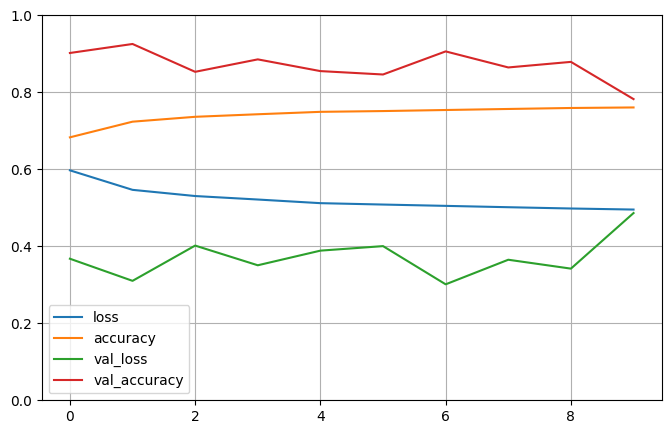

In [39]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

As seen above, we used a ModelCheckpoint callback to save the weights of our model during the epoch in which we had the lowest validation loss. We choose to continue training on this model. We also evaluate its performance on the test set as a form of "sanity check".

In [35]:
model2 = tf.keras.models.load_model("chexnet_transfer_learning_gpu.h5")
model2.evaluate(test_ds)

779/779 [==============================] - 29s 32ms/step - loss: 0.3047 - accuracy: 0.9062


[0.30473631620407104, 0.906184732913971]

As mentioned earlier, we performed a second round of training that now aims to modify the weights of the entire network. We performed an initial training of the final dense layer to stabilize its weights and its gradients, allowing us to not significantly alter the pretrained weights of the CheXNet-based model during this second round.

In [36]:
model2.summary()

Model: "transfer_learning_chexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 1024)              7037504   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [38]:
model2.layers[1].trainable = True
model2.summary()

Model: "transfer_learning_chexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 1024)              7037504   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


We now perform this second round of training. Note that we used a much lower learning rate in order to not alter the pretrained weights too abruptly.

In [42]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate = 0.0001) # reduced learning rate
model2.compile(optimizer = optimizer2, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb2 = keras.callbacks.ModelCheckpoint("chexnet_transfer_learning_gpu_unfreezed.h5", save_best_only=True)

In [43]:
with tf.device('/GPU:0'):
    history2 = model2.fit(x = train_ds,
                    epochs = 5, 
                    callbacks = [checkpoint_cb2],
                    validation_data = val_ds,
                    steps_per_epoch = steps_per_epoch
                    )

Epoch 1/5
7813/7813 [==============================] - 804s 101ms/step - loss: 0.1934 - accuracy: 0.9232 - val_loss: 0.1500 - val_accuracy: 0.9476
Epoch 2/5
7813/7813 [==============================] - 790s 101ms/step - loss: 0.0674 - accuracy: 0.9795 - val_loss: 0.0772 - val_accuracy: 0.9765
Epoch 3/5
7813/7813 [==============================] - 790s 101ms/step - loss: 0.0374 - accuracy: 0.9899 - val_loss: 0.0677 - val_accuracy: 0.9811
Epoch 4/5
7813/7813 [==============================] - 791s 101ms/step - loss: 0.0252 - accuracy: 0.9933 - val_loss: 0.0670 - val_accuracy: 0.9853
Epoch 5/5
7813/7813 [==============================] - 791s 101ms/step - loss: 0.0199 - accuracy: 0.9946 - val_loss: 0.0631 - val_accuracy: 0.9871


In [44]:
model2.evaluate(test_ds)

779/779 [==============================] - 27s 32ms/step - loss: 0.0601 - accuracy: 0.9871


[0.060111671686172485, 0.9870682954788208]

We then plot the training and validation accuracies and losses. Since the performance seems to improving, we decide to train the model further.

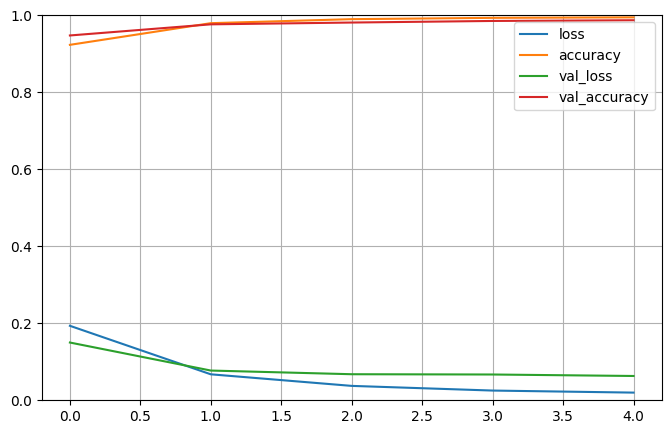

In [45]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [46]:
checkpoint_cb3 = keras.callbacks.ModelCheckpoint("chexnet_transfer_learning_gpu_unfreezed_final.h5", save_best_only=True)

In [47]:
with tf.device('/GPU:0'):
    history3 = model2.fit(x = train_ds,
                    epochs = 10, 
                    callbacks = [checkpoint_cb3],
                    validation_data = val_ds,
                    steps_per_epoch = steps_per_epoch,
                    initial_epoch = 5
                    )

Epoch 6/10
7813/7813 [==============================] - 791s 101ms/step - loss: 0.0154 - accuracy: 0.9957 - val_loss: 0.0711 - val_accuracy: 0.9857
Epoch 7/10
7813/7813 [==============================] - 789s 101ms/step - loss: 0.0132 - accuracy: 0.9964 - val_loss: 0.0746 - val_accuracy: 0.9864
Epoch 8/10
7813/7813 [==============================] - 789s 101ms/step - loss: 0.0123 - accuracy: 0.9966 - val_loss: 0.0747 - val_accuracy: 0.9872
Epoch 9/10
7813/7813 [==============================] - 790s 101ms/step - loss: 0.0101 - accuracy: 0.9971 - val_loss: 0.0807 - val_accuracy: 0.9884
Epoch 10/10
7813/7813 [==============================] - 789s 101ms/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 0.0814 - val_accuracy: 0.9824


We then plot the training and validation losses and accuracies. As seen in the plot as well as the training history above, the performance of the model on the validation set seems to be worse as compared to how it performed before.

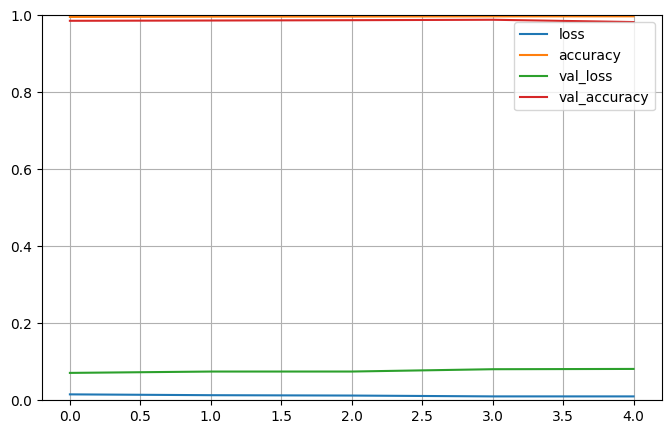

In [ ]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

We confirm this by evaluating both models on the test set.

In [ ]:
model3 = tf.keras.models.load_model("chexnet_transfer_learning_gpu_unfreezed_final.h5")
model3.evaluate(test_ds)

779/779 [==============================] - 29s 32ms/step - loss: 0.0673 - accuracy: 0.9853


[0.06734245270490646, 0.9853011965751648]

In [ ]:
model4 = tf.keras.models.load_model("chexnet_transfer_learning_gpu_unfreezed.h5")
model4.evaluate(test_ds)

779/779 [==============================] - 29s 32ms/step - loss: 0.0601 - accuracy: 0.9871


[0.06011169031262398, 0.9870682954788208]

As seen above, the model trained on the initial 5 epochs performed better on the training, validation, and test sets. Hence, we declare this to be our final model.